# Calibration of a volatility surface with Jupyter Notebook 

This exercise requires knowledge of Pandas, Numpy and Matplotlib and aims at calibrating the volatility surface of the SP500.

#### 1. Download the file implied_volatilities.csv on the adress below and load it in a dataframe using Pandas. Display the 5 first rows of the dataframe.

https://github.com/jeandamienvilliers/python_teaching/tree/master/2020/Python2


In [3]:
import pandas as pd
%matplotlib notebook 
# to get zoom-able & resize-able notebook

# Edit this line with the folder contain raw data files (.txt, .csv, .json...)
raw_data_folder=r"C:\Users\jeand\Desktop\Python course\Python exercise\raw data" #to be amended

df=pd.read_csv(raw_data_folder+"\\"+"implied_volatilities.csv")
df.head(5)

,Unnamed: 0,K,F,Moneyness,opt_type,T,price,implied_vol
0,0,2640.0,2749.329900,96.023398,put,0.02,3.45,21.479237
1,1,2025.0,2761.895472,73.319212,put,0.78,18.60,24.953517
2,2,2060.0,2749.329900,74.927349,put,0.02,0.05,64.951019
3,3,1625.0,2778.516658,58.484443,put,1.78,20.10,26.324363
4,4,2120.0,2749.329900,77.109699,put,0.02,0.05,58.917251


#### 2. Using the generated pandas dataframe , display in a sorted order the list of maturities on which option prices are available (column T)


In [4]:
list_maturities=list(set(df["T"])) # Conversion to set and then to list
list_maturities.sort() # Sorting the list
list_maturities # Display the list, no need for print

[0.02, 0.19, 0.54, 0.78, 1.28, 1.78, 2.78]

#### 3. Using Matplotlib, filter only options with the shortest maturity date and display the implied volatility as a function of the strike

<IPython.core.display.Javascript object>


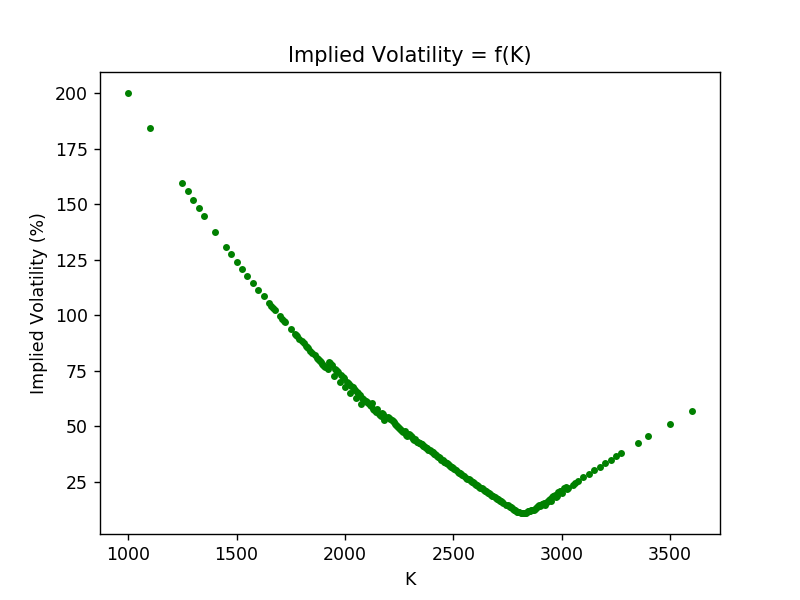

Text(0.5, 1.0, 'Implied Volatility = f(K)')

In [8]:
import matplotlib.pyplot as plt
min_maturity=min(list_maturities)
new_dataframe=df[df["T"]==min_maturity] #
fig, axes = plt.subplots() #create plot object    
axes.plot(new_dataframe["K"], new_dataframe["implied_vol"], 'g.') #plot the lists with a green line and dots
axes.set_xlabel('K') #change x label
axes.set_ylabel('Implied Volatility (%)') #change y label
axes.set_title('Implied Volatility = f(K)') # change title

#### 4. Using Matplotlib and the plot_trisurf function, plot the whole 3D implied volatility surface (Implied volatility = f(K,T))

Useful examples can be found in : https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#tri-surface-plots

<IPython.core.display.Javascript object>


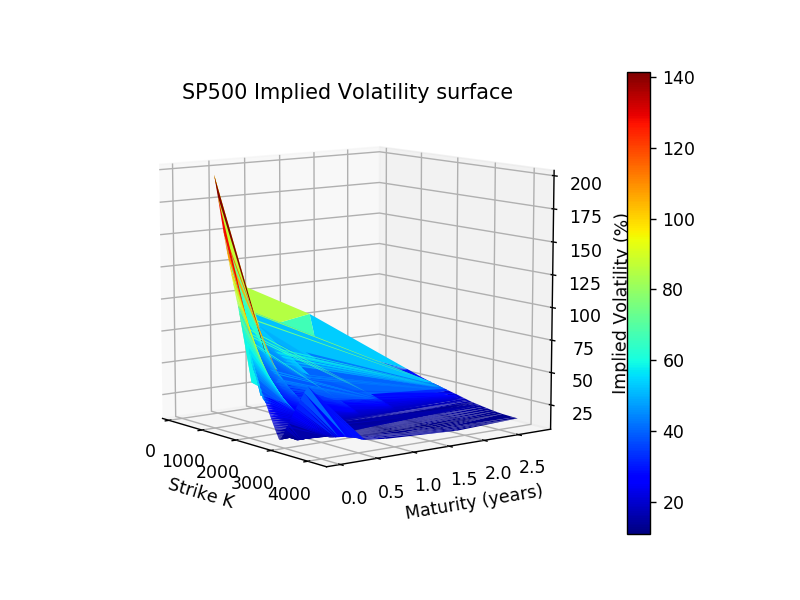

In [9]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure() #create figure
ax = fig.gca(projection='3d') #create 3d plot 
p=ax.plot_trisurf(df["K"], df["T"], df["implied_vol"], cmap=cm.jet, linewidth=0.2) #Plot 3d surface
ax.set_xlabel('Strike K') #change x label
ax.set_ylabel('Maturity (years)') #change y label
ax.set_zlabel('Implied Volatility (%)') #change y label
ax.set_title('SP500 Implied Volatility surface') # change title
fig.colorbar(p, ticks=np.arange(0,200,20)) #Add the colorbar scale

#### 5. We will now build a parametric quadratic function that we will consider as our "model" to be fitted on observed options prices. Define a function which takes as input a list of strikes, a list of forward, and 3 parameters ATMVol, Smile and Curve, and return the below quadratic function:


$G(K,F)=ATMVol + Smile \times \frac{K-F}{F} + Curve \times (\frac{K-F}{F})^{2}$

Plot the output of the function with the below arguments:

list_K=[1.0,2.0,3.0,4.0,5.0]

list_F=[3.0,3.0,3.0,3.0,3.0]

parameters=[0.1, -1,2]

<IPython.core.display.Javascript object>


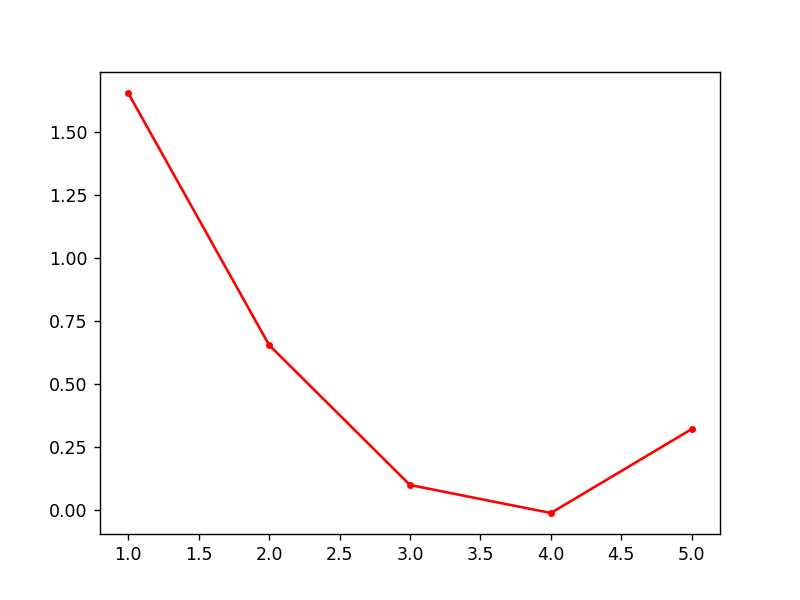

In [12]:
def quadratic_implied_vol(list_K,list_F, parameters):
    ATM_vol=parameters[0]
    Smile_term=parameters[1]*np.divide(np.subtract(list_K,list_F),list_F)
    Curve_term=parameters[2]*np.power(np.divide(np.subtract(list_K,list_F),list_F),2)
    return ATM_vol + Smile_term + Curve_term


fig, axes = plt.subplots() #create plot object    
list_K=[1.0,2.0,3.0,4.0,5.0]
list_F=[3.0,3.0,3.0,3.0,3.0]
parameters=[0.1, -1,2]
axes.plot(list_K, quadratic_implied_vol(list_K,list_F, parameters), 'r.-') #plot the lists with a green line and dots


#### 6. Using ipywidgets, create an interactive graph to be able to display what the quadratic function behaves moving the ATMVol, Smile and Curve parameters

In [13]:
from ipywidgets import interactive
import ipywidgets as widgets


def plotfunc(ATMVol, Smile, Curve):
    list_F=[100 for i in range(10)]
    list_K=np.arange(50,150, 10)
    parameters=[ATMVol, Smile, Curve]
    x=quadratic_implied_vol(list_K,list_F, parameters)
    plt.figure(figsize=(5,5)) # Initiate the graph
    print(list_K)
    print(quadratic_implied_vol)
    plt.plot(list_K, x, c='k', lw=3)
    plt.grid(True)
    plt.show()

y=interactive(plotfunc, ATMVol=(0, 5, 1), Smile=(-10, 10, 1), Curve=(0, 10, 1))

display(y)

interactive(children=(IntSlider(value=2, description='ATMVol', max=5), IntSlider(value=0, description='Smile',…

#### 7. The calibration of the model by minimizing the squared error between the implied volatility resulting from the model and the ones observed on the market. This means finding the parameters ATMVol, Smile, Curve in order to minimize the function:

$f=\sum_{0}^{Nstrikes} \sum_{0}^{Nmaturities} (\sigma_{market} - \sigma_{model})^{2}$

Create a funtion residuals which computes the error term $(\sigma_{market} - \sigma_{model})$

In [15]:
def residuals(parameters, y, K, F):
    return y - quadratic_implied_vol(K,F, parameters)

#### 8. Using the leastsq function of scipy.optimize, calibrate the 3 parameters ATMVol, Smile, Curve on the shortest maturity

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html



In [20]:
from scipy.optimize import leastsq

maturity_calibrated=list_maturities[3]
new_dataframe=df[df["T"]==maturity_calibrated]
observed_vols=list(new_dataframe["implied_vol"])
strikes=list(new_dataframe["K"])
forwards=list(new_dataframe["F"])
x0=np.array([10, -1, 1], dtype=float)
calibration_result, flag = leastsq(residuals, x0, args=(observed_vols, strikes, forwards))
print("The result of the calibration is (respectively V_ATM, Smile, Curve): ")
calibration_result

The result of the calibration is (respectively V_ATM, Smile, Curve): 


array([ 14.63233399, -18.52177522,  46.70611748])

#### 9.  Using Matplotlib,  display the result of our calibration, comparing it with the observed implied vol (the "target") 

<IPython.core.display.Javascript object>


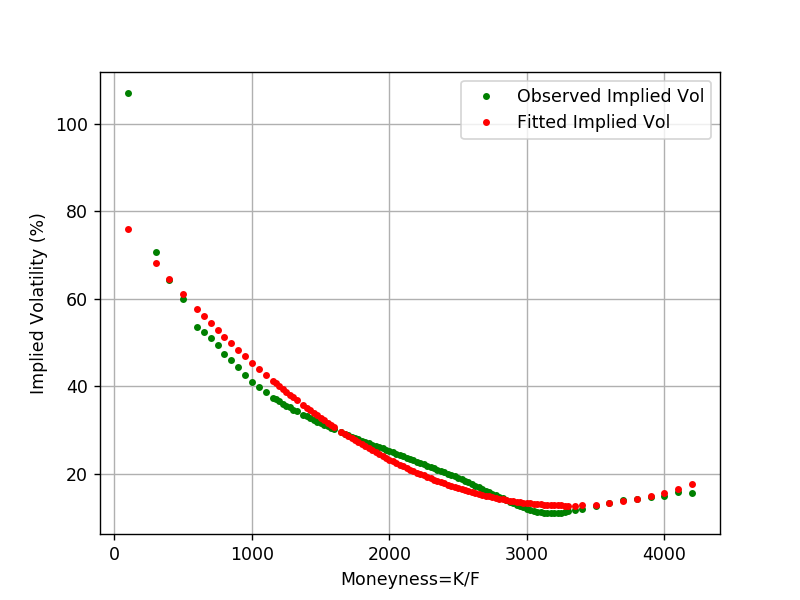

In [21]:
fig, axes = plt.subplots() #create plot object    
axes.plot(new_dataframe["K"], new_dataframe["implied_vol"], 'g.', label='Observed Implied Vol') #plot the lists with a green line and dots  
axes.plot(new_dataframe["K"], quadratic_implied_vol(new_dataframe["K"],new_dataframe["F"], calibration_result), 'r.', label='Fitted Implied Vol') 
axes.legend(loc='best')
axes.set_xlabel('Moneyness=K/F') #change x label
axes.set_ylabel('Implied Volatility (%)') #change y label
axes.grid(True)

#### 10.  Repeat the calibration process on the 4th maturity. What do you observe and what can you conclude ?